# 1 - Import requirements

In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report

import torch
import torch.nn as nn

from torch.utils.data import Dataset, DataLoader, Subset

from tqdm import tqdm

# 2 - Prepare data

In [2]:
label_mapping = {
    'BUY': 0,
    'SELL': 1,
    'HOLD': 2
}

def map_label(x):
    return label_mapping[x] if x in label_mapping else x

In [3]:
def load_shape(shape_path):
    with open(shape_path, 'r') as f:
        shape = f.readlines()
        n_samples = int(shape[0])
        seq_len = int(shape[1])
        n_features = int(shape[2])
    return n_samples, seq_len, n_features

class TradingDataset(Dataset):
    def __init__(self, save_path, n_samples, sequence_length, n_features):
        self.save_path = save_path
        self.n_samples = n_samples
        self.sequences = np.memmap(f'{save_path}/sequences.dat', dtype=np.float32, mode='r', 
                                 shape=(n_samples, sequence_length, n_features))
        self.labels = np.memmap(f'{save_path}/labels.dat', dtype=np.int64, mode='r', 
                              shape=(n_samples,))
    
    def __len__(self):
        return self.n_samples
    
    def __getitem__(self, idx):
        seq = self.sequences[idx].copy()  # Tạo bản sao writable
        lbl = self.labels[idx].copy()
        return torch.from_numpy(seq).float(), torch.from_numpy(np.array([lbl])).float()[0]

def prepare_transformer_input(train_shape_path, val_shape_path, test_shape_path, data_path, batch_size=32):    
    n_train_samples, sequence_length, n_features = load_shape(train_shape_path)
    n_val_samples, _, _ = load_shape(val_shape_path)
    n_test_samples, _, _ = load_shape(test_shape_path)
    
    train_path = f'{data_path}/train'
    val_path = f'{data_path}/val'
    test_path = f'{data_path}/test'
    
    # Tạo datasets
    train_dataset = TradingDataset(train_path, n_train_samples, sequence_length, n_features)
    val_dataset = TradingDataset(val_path, n_val_samples, sequence_length, n_features)
    test_dataset = TradingDataset(test_path, n_test_samples, sequence_length, n_features)
    
    # Tạo dataloaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    return train_loader, val_loader, test_loader

In [5]:
train_shape_path = 'data/regression/train/shape.txt'
val_shape_path = 'data/regression/val/shape.txt'
test_shape_path = 'data/regression/test/shape.txt'


train_loader, val_loader, test_loader = prepare_transformer_input(
    train_shape_path, val_shape_path, test_shape_path,
    data_path='data/regression',
    batch_size=64
)

In [6]:
# Kiểm tra
sample_batch = next(iter(train_loader))
print("Batch input shape:", sample_batch[0].shape)
print("Batch labels shape:", sample_batch[1].shape)
print("\nExample input shape for Transformer:", sample_batch[0][0].shape)
print(sample_batch[0][0])
print("Number of batches:", len(train_loader))

Batch input shape: torch.Size([64, 128, 27])
Batch labels shape: torch.Size([64])

Example input shape for Transformer: torch.Size([128, 27])
tensor([[-0.7127, -0.7133, -0.7126,  ..., -0.6439,  0.8317,  0.8950],
        [-0.7129, -0.7134, -0.7127,  ..., -0.6439,  0.8317,  0.8950],
        [-0.7132, -0.7137, -0.7134,  ..., -0.6439,  0.8317,  0.8950],
        ...,
        [-0.7067, -0.7072, -0.7065,  ..., -1.1719,  0.8317,  0.8950],
        [-0.7070, -0.7071, -0.7064,  ..., -1.1719,  0.8317,  0.8950],
        [-0.7065, -0.7067, -0.7068,  ..., -1.1719,  0.8317,  0.8950]])
Number of batches: 1642


# 3 - Build model

In [7]:
from torch.nn import TransformerEncoder, TransformerEncoderLayer
class TradingTransformer(nn.Module):
    def __init__(self, 
                 num_features, 
                 output_dim=3, 
                 d_model=512,
                 nhead=8,
                 num_layers=6,
                 dropout=0.1):
        super().__init__()
        
        # 1. Feature Projection
        self.input_proj = nn.Linear(num_features, d_model)
        
        # 2. Positional Encoding (Learnable)
        self.pos_encoder = LearnablePositionalEncoding(d_model, dropout)
        
        # 3. Transformer Encoder
        encoder_layers = TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=d_model*4,
            dropout=dropout,
            batch_first=True 
        )
        self.transformer_encoder = TransformerEncoder(encoder_layers, num_layers)
        
        # 4. Classification Head
        self.classifier = nn.Sequential(
            nn.Linear(d_model, d_model//2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_model//2, output_dim)
        )
        
    #     # 5. Initialize weights
    #     self.init_weights()

    # def init_weights(self):
    #     for p in self.parameters():
    #         if p.dim() > 1:
    #             nn.init.xavier_uniform_(p)

    def forward(self, src):
        """
        Args:
            src: Tensor shape [batch_size, seq_len, num_features]
        Returns:
            output: Tensor shape [batch_size, output_dim]
        """
        # Project input features
        x = self.input_proj(src)  # [B, S, D]
        
        # Add positional encoding
        x = self.pos_encoder(x)
        
        # Transformer processing
        memory = self.transformer_encoder(x)  # [B, S, D]
        
        # Get last time step output
        last_output = memory[:, -1, :]  # [B, D]
        
        # Classification
        return self.classifier(last_output)

class LearnablePositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)
        self.position_emb = nn.Parameter(torch.zeros(max_len, d_model))
        nn.init.normal_(self.position_emb, mean=0, std=0.02)

    def forward(self, x):
        """
        Args:
            x: Tensor shape [B, S, D]
        """
        positions = self.position_emb[:x.size(1), :]  # [S, D]
        x = x + positions.unsqueeze(0)  # [B, S, D]
        return self.dropout(x)

In [8]:
N_FEATURES = 27
model = TradingTransformer(num_features=N_FEATURES, output_dim=1)

model(sample_batch[0])[:, -1].shape, sample_batch[1].shape

(torch.Size([64]), torch.Size([64]))

In [9]:
from torchinfo import summary
print(summary(model, (64, 128, 27)))

Layer (type:depth-idx)                        Output Shape              Param #
TradingTransformer                            [64, 1]                   --
├─Linear: 1-1                                 [64, 128, 512]            14,336
├─LearnablePositionalEncoding: 1-2            [64, 128, 512]            2,560,000
│    └─Dropout: 2-1                           [64, 128, 512]            --
├─TransformerEncoder: 1-3                     [64, 128, 512]            --
│    └─ModuleList: 2-2                        --                        --
│    │    └─TransformerEncoderLayer: 3-1      [64, 128, 512]            3,152,384
│    │    └─TransformerEncoderLayer: 3-2      [64, 128, 512]            3,152,384
│    │    └─TransformerEncoderLayer: 3-3      [64, 128, 512]            3,152,384
│    │    └─TransformerEncoderLayer: 3-4      [64, 128, 512]            3,152,384
│    │    └─TransformerEncoderLayer: 3-5      [64, 128, 512]            3,152,384
│    │    └─TransformerEncoderLayer: 3-6      [64

c:\Users\longt\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\transformer.py:720: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  return torch._transformer_encoder_layer_fwd(


# 4 - Train and Evaluate model

In [10]:
class EarlyStopping:
    def __init__(self, patience=3, min_delta=0.001):
        """
        patience: Số epoch chờ mà không cải thiện trước khi dừng
        min_delta: Độ cải thiện tối thiểu để coi là tốt hơn
        """
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter}/{self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0
            
def eval_model(model, val_loader, criterion, device):
    model.to(device)
    model.eval()
    running_loss = 0.0
    
    with torch.no_grad():
        for images, labels in tqdm(val_loader, unit='batch', desc='\tEvaluating: '):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)[:, -1]
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
    
    epoch_loss = running_loss / len(val_loader)
    
    return epoch_loss

def train_model(model, train_loader, criterion, optimizer, scheduler, device):
    model.to(device)
    model.train()
    running_loss = 0.0
        
    for images, labels in tqdm(train_loader, unit='batch', desc=f'\tTraining: '):
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)[:, -1]
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    epoch_loss = running_loss / len(train_loader)
    
    scheduler.step()
    
    return epoch_loss

In [ ]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [11]:
NUM_EPOCHS = 20
PATIENCE = 3
MIN_DELTA = 0.0005
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.cuda.empty_cache()
    
train_losses = []
val_losses = []

early_stopping = EarlyStopping(patience=PATIENCE, min_delta=MIN_DELTA)

for epoch in range(NUM_EPOCHS):
    print(f'Epoch [{epoch + 1}/{NUM_EPOCHS}]')
    
    train_loss = train_model(model, train_loader, criterion, optimizer, scheduler, DEVICE)
    val_loss = eval_model(model, val_loader, criterion, DEVICE)
    
    print(f'\tTrain Loss: {train_loss:.4f}')
    print(f'\tVal Loss: {val_loss:.4f}')
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    # Kiểm tra Early Stopping
    early_stopping(val_loss)
    if early_stopping.early_stop:
        print("Early stopping triggered!")
        break
    print('===================================================')

Epoch [1/20]


	Evaluating: 100%|██████████| 549/549 [00:36<00:00, 14.98batch/s]


	Train Loss: 0.0560
	Val Loss: 0.0353
Epoch [2/20]


	Evaluating: 100%|██████████| 549/549 [00:31<00:00, 17.44batch/s]


	Train Loss: 0.0614
	Val Loss: 0.0361
EarlyStopping counter: 1/3
Epoch [3/20]


	Evaluating: 100%|██████████| 549/549 [00:31<00:00, 17.44batch/s]


	Train Loss: 0.0632
	Val Loss: 0.0351
EarlyStopping counter: 2/3
Epoch [4/20]


	Evaluating: 100%|██████████| 549/549 [00:31<00:00, 17.43batch/s]

	Train Loss: 0.0656
	Val Loss: 0.0361
EarlyStopping counter: 3/3
Early stopping triggered!


In [16]:
import matplotlib.pyplot as plt
def plot_training_results(train_losses, val_losses):
    """
    Vẽ biểu đồ kết quả huấn luyện: loss và accuracy cho train và validation.
    
    Parameters:
    - train_losses: List các giá trị loss của train qua các epoch
    - train_accs: List các giá trị accuracy của train qua các epoch
    - val_losses: List các giá trị loss của validation qua các epoch
    - val_accs: List các giá trị accuracy của validation qua các epoch
    """
    epochs = range(1, len(train_losses) + 1)
    
    # Tạo figure với 2x2 subplot
    plt.figure(figsize=(6, 6))
    
    # Subplot 1: Train Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'b-', label='Train Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.legend()
    plt.grid(True)
    
    # Subplot 3: Validation Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, val_losses, 'r-', label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Validation Loss')
    plt.legend()
    plt.grid(True)
    
    # Điều chỉnh layout và hiển thị
    plt.tight_layout()
    plt.show()

plot_training_results(train_losses, val_losses)

NameError: name 'train_losses' is not defined

In [21]:
torch.save(model.state_dict(), 'model.pth')

In [13]:
import pickle
scaler = pickle.load(open('data/regression_scaler.pkl', 'rb'))

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TradingTransformer(num_features=N_FEATURES, output_dim=1)
model.load_state_dict(torch.load('save/models/reg-rf.pth', weights_only=True))

<All keys matched successfully>

In [17]:
def test_model(model, test_loader, device='cuda' if torch.cuda.is_available() else 'cpu'):
    model.to(device)
    model.eval()

    all_preds = []
    all_labels = []

    i = 0
    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            batch_x = batch_x.to(device)  # [B, seq_len, n_features]
            batch_y = batch_y.to(device)

            outputs = model(batch_x)  # Expecting [B, output_dim]

            features = batch_x[:, -1]

            outputs = torch.cat((features, outputs), dim=-1)
            batch_y = torch.cat((features, batch_y.unsqueeze(-1)), dim=-1)
            
            outputs = scaler.inverse_transform(outputs.cpu().numpy())
            batch_y = scaler.inverse_transform(batch_y.cpu().numpy())

            all_preds.extend(outputs[:, -1])
            all_labels.extend(batch_y[:, -1])
            i += 1
            if i == 100:
                break
    print('---------------------')
    xaxis = np.arange(len(all_preds))
    plt.figure(figsize=(8, 10))
    # Subplot 1: Train Loss
    plt.plot(xaxis, all_preds, 'b-', label='Prediction')
    plt.xlabel('')
    plt.ylabel('Scaled price')
    plt.title('Prediction')
    plt.legend()
    plt.grid(True)
    
    # Subplot 3: Validation Loss
    plt.plot(xaxis, all_labels, 'r-', label='Groundtruth')
    plt.xlabel('')
    plt.ylabel('Scaled price')
    plt.title('Prediction')
    plt.legend()
    plt.grid(True)

---------------------


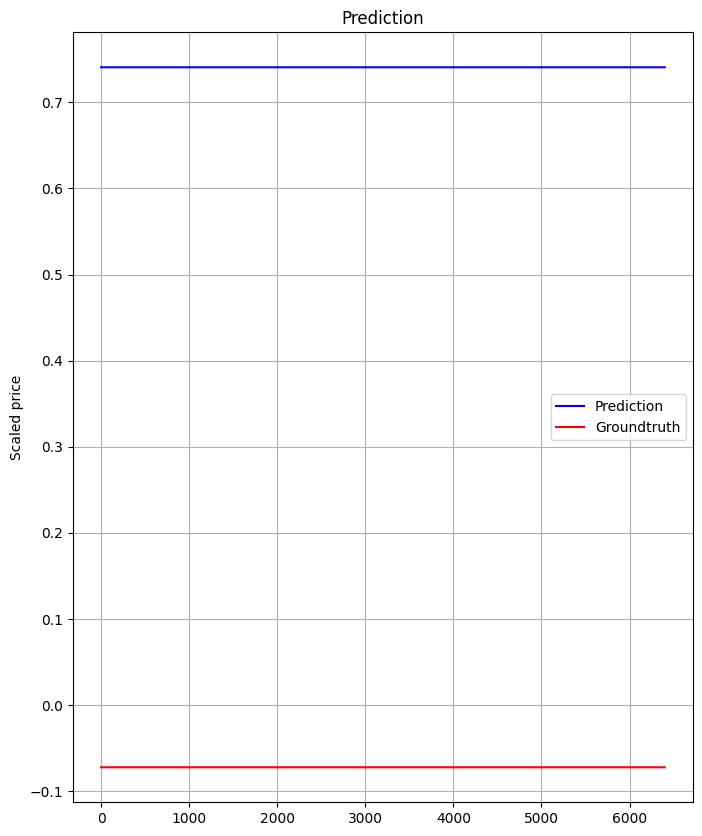

In [18]:
test_model(model, train_loader, DEVICE)

---------------------


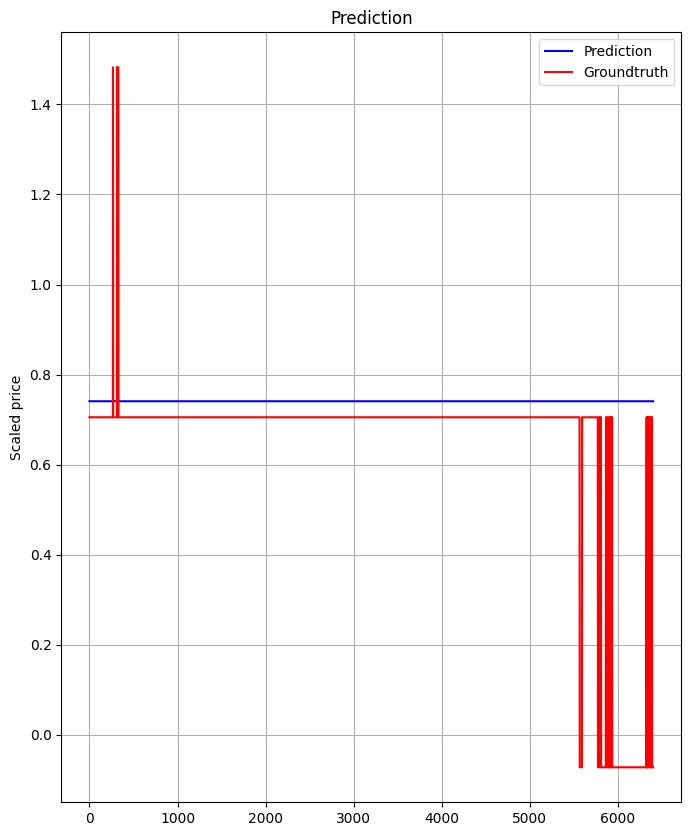

In [52]:
test_model(model, val_loader, DEVICE)

---------------------


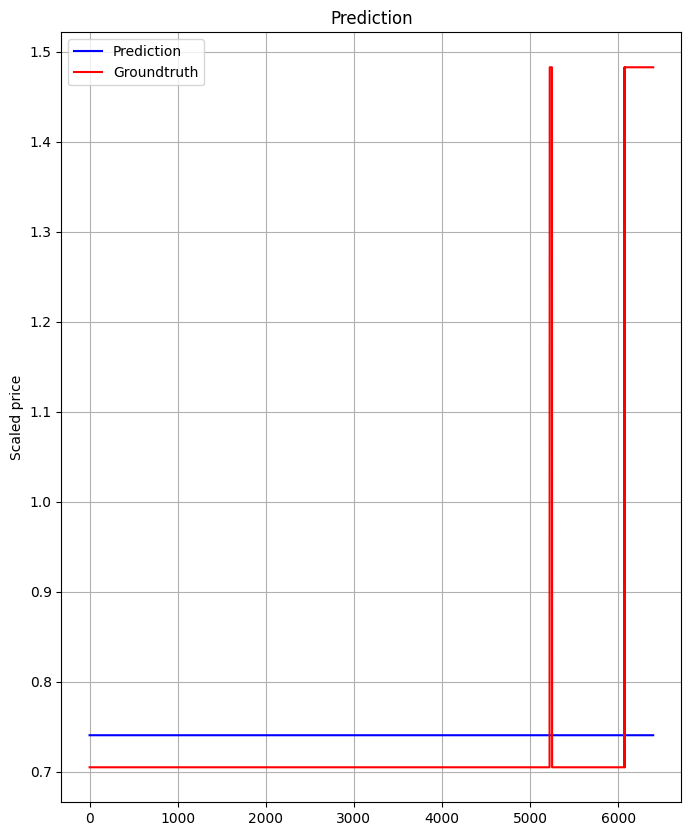

In [53]:
test_model(model, test_loader, DEVICE)

In [18]:
def get_prediction(model, inputs, device):
    # inputs = [B, S, N]
    model.to(device)
    model.eval()
    with torch.no_grad():
        inputs = inputs.to(device)
        outputs = model(inputs)
        preds = torch.argmax(outputs, dim=-1)
    return preds.cpu().numpy()

In [19]:
batch = next(iter(test_loader))
inputs, labels = batch[0], batch[1]

get_prediction(model, inputs, DEVICE)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])